###Install and import the required libraries

In [1]:
!pip install rlcard
import numpy as np
from rlcard.games.limitholdem import Dealer
from rlcard.games.base import Card
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from itertools import combinations, product, permutations
from math import floor
import time
import sys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=325799 sha256=1b62c804511eb346655024fea8f1e5a32544e686bb85e5b19ef2f2435ad1819c
  Stored in directory: /root/.cache/pip/wheels/a5/0a/39/26d73b035027276e526bec94b0217ed799109d7890c34a7d9b
Successfully built rlcard


### Declare some basic global variables

In [2]:
CHECK = 0
BET = 1
CALL = 2
RAISE = 3
FOLD = 4

ANTE = 0.5

### Declare some basic helper functions

In [3]:
def check_transition(round_no, player, action):
    """
        Check whether the given action by the given player at the given round
        incurs a transition (round change or game over).
    """

    next_round = False

    # round 1 ends when either agent calls or p2 checks

    if (round_no==1 and (action==CALL or (player==2 and action==CHECK))):
        next_round = True

    # game is over when anyone folds

    game_over = False
    if action == FOLD:
        game_over = True

    if round_no == 2:
        if (player==1 and action==CALL) or (player==2 and (action==CALL or action==CHECK)):
            game_over = True

    return next_round, game_over

def action_name(action):
    """
        Return the name of the action that corresponds to the given number.
    """

    actions = [
        "Check",
        "Bet",
        "Call",
        "Raise",
        "Fold",
    ]

    return actions[action]

def init_deck(suits = ['S', 'H' , "D" , 'C'], ranks = ['T', 'J', 'Q' , 'K', 'A']):
    """
        Create and return a deck consisting of cards of the given suits and ranks.

        The length of the returned deck should be len(suits)*len(ranks).
    """

    return [Card(suit,rank) for suit in suits for rank in ranks]

def get_rank(rank):
    if rank == '':
        return -1
    elif rank == "T":
        return 1
    elif rank == "J":
        return 2
    elif rank == "Q":
        return 3
    elif rank == "K":
        return 4
    elif rank == "A":
        return 5
    return 0

def state_to_str(state):
    """
        Convert a state to a printable str.
    """
    cards = state[:3]
    cards = tuple([str(x) if x is not None else "_" for x in cards])
    return f"state ({cards} {state[3:]})"

###Declare the functions that handle the creation of the environment and state space

Those are the functions that calculate the permutations of the states and that characterize actions as legal or illegal in particular states

In [4]:
def make_state_space(deck, private_cards, public_cards, other_fields, other_fields_legality, actions):
    """
        Create a state space out of the given deck, with the given numbers of private
        and public cards and with the rest of the fields concatenated to each state.

        Should this return an iterator? The state space can be quite big, but also its a
        bummer to only be able to access it through an iterator and not arbitrarily (by index),
        so no.

        Returns a list of tuples, each corresponding to a state.
    """

    card_arrangements = generate_card_arrangements(deck, private_cards, public_cards)

    other_fields_arrangements = list(product(*other_fields))

    state_space = [state + field for state, field in product(card_arrangements, other_fields_arrangements)]

    legality = {}

    for state in state_space:

        # each state gets the legality of the non-card fields in it
        noncard_fields_state = state[-len(other_fields):]

        legality.update({state: other_fields_legality[noncard_fields_state]})

    return state_space, legality

def generate_card_arrangements(deck, private_cards, public_cards):
    """
        Generate and return all possible arrangements of the cards in the given deck, with
        the given numbers of private cards (in the players hand) and public ones (on the
        table). The only assumption being made is that all public cards are revealed at once
        (they're either all known or all unknown).

        Returns a list of tuples in each of which the first elements are the player's cards
        and the rest are the public ones. Includes a state where the public ones are unknown.
    """

    arrangements = []

    # for each first card (this can be more generalized as combinations of cards in deck by #cards in hand)
    for cards in combinations(deck, private_cards):

        # remove it from the deck
        other_cards = list(set(deck) - set(cards))

        # generate the possible combinations of the rest (the 2 here is the number of public cards)
        rest_combinations = list(permutations(other_cards, public_cards))

        # add the empty combination
        rest_combinations += [tuple([None]*public_cards)]

        # combine the combinations with the card
        for arrangement in rest_combinations:
            arrangements.append(tuple([card for card in cards]) + (arrangement))

    return arrangements

def create_default_env():
    """
        Creates and returns the default environment:
            - available actions
            - cards from 10 to A, all suits
            - state space has the following fields (plus public and private cards):
                - player ID (max 2)
                - round #   (max 2)
                - own chips (max 4)
                - opp chips (max 4)

        Also creates and returns a state-action legality dict that can be used
        to derive the complete one when compiling the complete state space.

        Basically provides everything necessary to create an environment, so we
        can proceed in an environment-agnostic way and compile the complete
        state space and legality dictionary.
    """

    # 0) available actions
    actions = range(5)

    # 1) card suits and ranks
    suits = ['S', 'H' , "D" , 'C']
    ranks = ['T', 'J', 'Q' , 'K', 'A']

    # 2) state space fields beside cards
    player_ids = [1, 2]
    rounds = [1, 2]
    own_chips = list(range(5))
    opp_chips = list(range(5))
    fields = [
        player_ids,
        rounds,
        own_chips,
        opp_chips
    ]
    player_id_i = 0
    round_i = 1
    own_chips_i = 2
    opp_chips_i = 3

    # 3) combinations of other fields
    other_fields_arrangements = list(product(*fields))

    # 4) state-action legality (besides cards - cards don't matter as far as legality is concerned)
    other_fields_legality = {state: {action: False for action in actions} for state in other_fields_arrangements}

    for state, actions in other_fields_legality.items():

        # there are differenct legal actions for player 1 and player 2
        if state[player_id_i] == 1:

            # the state of the game is reflected on the # of chips each player has bet
            if state[own_chips_i] == state[opp_chips_i]:        # then its our move and we check/bet
                actions.update({CHECK: True})
                actions.update({BET: True})
            elif state[own_chips_i] < state[opp_chips_i]:       # then we're replying to a bet or a raise
                actions.update({CALL: True})
                actions.update({FOLD: True})

        elif state[player_id_i] == 2:

            # the state of the game is reflected on the # of chips each player has bet
            if state[own_chips_i] == state[opp_chips_i]:        # then its our move and we check/bet
                actions.update({CHECK: True})
                actions.update({BET: True})
            elif state[own_chips_i] < state[opp_chips_i]:       # then we're replying to a bet
                actions.update({CALL: True})
                actions.update({FOLD: True})
                actions.update({RAISE: True})

        else:
            # error
            print(f"There is an error in state {state}! player id '{state[player_id_i]} is invalid")

        other_fields_legality.update({state: actions})

    return suits, ranks, fields, other_fields_arrangements, player_id_i, round_i, own_chips_i, opp_chips_i, other_fields_legality, actions

def print_state_space_and_legality(state_space, legality):
    """
        Print the state space and the legal actions for every state.

        Used for debugging.
    """

    for state in state_space:
        cards = state[:3]
        cards = tuple([str(x) for x in cards])
        #print(f"state ({cards} {state[3:]}), legal actions: {[action_name(action) for action, legal in legality[state].items() if legal]}")
        print(f"state ({cards} {state[3:]}), legal actions: {legality[state].items()}")

###Declare the basic parts of the environment
The dealer and the judger (the class implementing the logic for deriving the winner and distributing the pot at the end of each game)

In [5]:
class Dealer:
    """
        Dealer initializes a deck given by init_deck
        shufles the the deck aka randomizes the cards order
        deals a card , gives the last card in deck

        Returns:
        card
    """
    def __init__(self, np_random, suits = ['S', 'H' , "D" , 'C'], ranks = ['T', 'J', 'Q' , 'K', 'A'], deck=None):
        self.np_random = np_random
        self.deck = init_deck(suits, ranks) if deck is None else deck
        self.shuffle()
        self.pot = 0

    def reset(self, suits = ['S', 'H' , "D" , 'C'], ranks = ['T', 'J', 'Q' , 'K', 'A'], deck=None):
        self.deck = init_deck(suits, ranks) if deck is None else deck
        self.shuffle()

    def shuffle(self):
        self.np_random.shuffle(self.deck)

    def deal_card(self):
        return self.deck.pop()

class Judger:
    ''' The Judger class which deciedes the winner between 2 players given their cards and the public  too
        Returns a list of the chips won or lost for every player
    '''
    def __init__(self, np_random):
        ''' Initialize a judger class
        '''
        self.np_random = np_random

    @staticmethod
    def judge_game(players, public_cards):
        ''' Judge the winner of the game.

        Args:
            players (list): The list of players who play the game
            public_card (object): The public card that seen by all the players

        Returns:
            (list): Each entry of the list corresponds to one entry of the
        '''
        # Judge who are the winners
        winners = [0] * len(players)
        fold_count = 0
        ranks_list = []

        #save ranks of the 2 players in ranks list
        for player in players:
            ranks_list.append(get_rank(player.hand.rank))


         #keep track of the max rank between the 2 players
        max_rank = max(ranks_list)

        # First check if anyone has folded then the other wins
        if players[0].status== 'folded':
            winners[1]= 1
        if players[1].status== 'folded':
            winners[0]= 1


        # If any of the players matches both public cards wins. Both the 2 players can win and pot is splitted
        if sum(winners) < 1:
            for idx, player in enumerate(players):
                if player.hand.rank == public_cards[0].rank and player.hand.rank == public_cards[1].rank:
                    winners[idx] = 1

        # If one of the players matches one public cards wins. if both  then check the higher rank , again both can win
        if sum(winners) < 1:
            #Both have one pair
            if (players[0].hand.rank == public_cards[0].rank or players[0].hand.rank == public_cards[1].rank) and (players[1].hand.rank == public_cards[0].rank or players[1].hand.rank == public_cards[1].rank):

                #check the rank
                for idx, player in enumerate(players):
                    if get_rank(player.hand.rank) == max_rank:
                        winners[idx] = 1


            #Only one has a pair
            else:
                for idx, player in enumerate(players):
                    if player.hand.rank == public_cards[0].rank or player.hand.rank == public_cards[1].rank:
                        winners[idx] = 1

        # If non of the above conditions, the winner player is the one with the highest card rank
        if sum(winners) < 1:
            max_index = [i for i, j in enumerate(ranks_list) if j == max_rank]
            for idx in max_index:
                winners[idx] = 1

        if sum(winners) < 1:
            print('ERROR on judging')
        # Compute the total chips
        total = 0
        for p in players:
            total += p.in_chips

        # split the winnings in case there are 2 winners
        each_win = float(total) / sum(winners)
        payoffs = []

        # Check every player's winning state and give him the credit
        for i, _ in enumerate(players):
            # winner
            if winners[i] == 1:
                #if player is a winner give him wiining_chips- contributed_chips so  he gets the clear profit
                payoffs.append(each_win - players[i].in_chips)
            # losser
            else:
                #if player is a losser give him -his contributed_chips
                payoffs.append(float(-players[i].in_chips))

        #print(f"\tpayoffs are {payoffs}")

        return payoffs

###Declare the basic types of opponents that the Q-Learning algorithm will train with and face in games

A random agent that chooses one of the legal actions by chance in every state

A threshold agent that bets or raises if its cards satisfy some conditions

An abstract base class (that ended up only being a base for one class) is also defined here

In [6]:
class RandomAgent():
    """
    Random agent implitation
    The action of the agent is decided by a random value

    Dont forgret that an agent is a player too.
"""

    def __init__(self,ID):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.ID = ID
        #playe's status
        self.status = 'alive'

        self.type= 'Random'

        #player's hand
        self.hand = None
        # The chips that this player has put in until now
        self.in_chips = 0

        self.all_chips= 0

        # self.player_id = player_id
    """
    Action of the agent given the state he is in
    """
    def step(self, available_actions):
        """
            Decide the action of the agent given the state
        """

        index = np.random.choice(len(available_actions))
        return available_actions[index]

class ThresholdAgent():
    """
    Threshold agent implitation

    The action of the agent is decided by by the rank of his card
    He basically plays aggressively  at first round with high values of 'K' and 'A' betting or raisinig , callin with Q and folding with '10' and 'J'
    For second round he raises or bets with one pair at least and folds  or checks every other time


    Dont forgret that an agent is a player too.
    """

    def __init__(self,ID):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.ID=ID
        #playe's status
        self.status = 'alive'

        self.type= 'Threshold'

        #player's hand
        self.hand = None
        # The chips that this player has put in until now
        self.in_chips = 0

        self.all_chips= 0

        # self.player_id = player_id
    """
    Action of the agent given the state he is in
    """

    def step(self,available_actions, round_no, public_cards):
        """
            Decide the action of the agent given the state and the public_cards and playe's hand
            threshold players bet or raises with K and A in the first round and with a pair in the second one.
        """

        hand=self.hand

        if round_no == 1:
            if hand.rank in ["K", "A"]:
                if RAISE in available_actions:
                    action = RAISE
                elif BET in available_actions:
                    action = BET
                elif CALL in available_actions:
                    action = CALL
                elif CHECK in available_actions:
                    action = CHECK
                elif FOLD in available_actions:
                    action = FOLD
                else:
                    print(f"Error! Threshold agent at round {round_no}, hand {str(hand)} and public cards {[str(x) for x in public_cards]} with no valid actions (available actions: {available_actions})")
            else:
                if CALL in available_actions:
                    action = CALL
                elif CHECK in available_actions:
                    action = CHECK
                elif FOLD in available_actions:
                    action = FOLD
                else:
                    print(f"Error! Threshold agent at round {round_no}, hand {str(hand)} and public cards {[str(x) for x in public_cards]} with no valid actions (available actions: {available_actions})")
        elif round_no == 2:
            if hand.rank in [card.rank for card in self.public_cards]:
                if RAISE in available_actions:
                    action = RAISE
                elif BET in available_actions:
                    action = BET
                elif CALL in available_actions:
                    action = CALL
                elif CHECK in available_actions:
                    action = CHECK
                elif FOLD in available_actions:
                    action = FOLD
                else:
                    print(f"Error! Threshold agent at round {round_no}, hand {str(hand)} and public cards {[str(x) for x in public_cards]} with no valid actions (available actions: {available_actions})")
            else:
                if CALL in available_actions:
                    action = CALL
                if CHECK in available_actions:
                    action = CHECK
                elif FOLD in available_actions:
                    action = FOLD
                else:
                    print(f"Error! Threshold agent at round {round_no}, hand {str(hand)} and public cards {[str(x) for x in public_cards]} with no valid actions (available actions: {available_actions})")
        else:
            print(f"Invalid round number {round_no}!")

        return action

class BaseAgent(ABC):
    """
        Abstract Base Class (ABC) for agents that can interact with the environment.
    """

    def __init__(self, id, state_space, action_space):
        self.ID = id
        self.type= None
        self.state_space = state_space
        self.action_space = action_space
        self.all_chips= 0
        self.policy = None
        self.state = None

        self.hand = None
        self.in_chips = 0
        self.status = 'alive'

    @abstractmethod
    def step(self):
        pass

###Define the environment in which the Q-Learning agent will train and play

In [7]:
class QEnv():
    """
        An environment for the implementation of the Q learning algorithm.

        Does not need to be separate however i got dizzy trying to read the other one.
    """

    def __init__(self, suits, ranks, non_card_state_fields, non_card_fields_legality, actions, player_id_i, round_i, own_chips_i, opp_chips_i):
        """
            Initialize a the environment:
                - max rounds
                - suits & ranks
                - sate space
                - action space
                - state-action legality
                - dealer
                - judger
                - agents
                - trainer opponent state
        """

        self.max_rounds = 2
        self.suits = suits
        self.ranks = ranks
        self.deck = init_deck(self.suits, self.ranks)
        self.state_space, self.legality = make_state_space(
            self.deck,
            private_cards=1,
            public_cards=2,
            other_fields=non_card_state_fields,
            other_fields_legality=non_card_fields_legality,
            actions=actions
        )
        self.actions = actions
        self.agents:list[QLearningAgent] = [None, None]

        # initialize an RNG for the dealer (and the judger...?)
        self.rng = np.random.RandomState()
        self.dealer = Dealer(self.rng, deck=self.deck)
        self.judger = Judger(self.rng)  # why does the judger need an RNG?

        # initialize state space controls
        self.player_id_i = player_id_i
        self.round_i = round_i
        self.own_chips_i = own_chips_i
        self.opp_chips_i = opp_chips_i

        self.state = None

        self.reset()

    def reset(self):
        """
            Reset the state space. Resets:
                - deck
                - dealer
                - public and private cards
                - chips bet
                - round_no
                - trainer opponent state
        """

        self.dealer.reset()
        self.round_no = 1
        self.public_cards = [None, None]
        self.hands = [None, None]
        self.chips_in = [0, 0]
        self.state = None

    def new_game(self, requesting_player, agent1, agent2, v=False):
        """
            Create a new game setting, set the internal variables accordingly and return
            the initial state of the requesting player.
        """

        # requesting player index
        _p = requesting_player-1

        # set up the new game
        self.reset()
        self.public_cards = [self.dealer.deal_card() for i in range(2)]
        self.hands = [self.dealer.deal_card() for i in range(2)]
        self.chips_in = [0, 0]

        # create the state of the requesting player
        req_state = (
            self.hands[_p],
            None, None,
            _p + 1,
            self.round_no,
            self.chips_in[_p],
            self.chips_in[not _p],
        )

        # create the state of the opponent that will be incorporated in the environment
        self.state = (
            self.hands[not _p],
            None, None,
            (not _p) + 1,
            self.round_no,
            self.chips_in[not _p],
            self.chips_in[_p],
        )

        self.agents = [agent1, agent2]
        self.agents[0].hand = self.hands[0]
        self.agents[1].hand = self.hands[1]
        for agent in self.agents:
            agent.in_chips = 0
            agent.status="alive"

        if v:
            print("="*70)
            print("New game created!")
            print(f"agent state: {state_to_str(req_state)}, bet: ")
            print(f"env state: {state_to_str(self.state)}")
            print(f"public cards (not shown yet): {[str(x) for x in self.public_cards]}")
            print("="*70)

        # if the new game was created by player 2, then let the opponent play a round first
        if requesting_player == 2:
            print(f"game requested by player 2")
            available_actions = [action for action in self.actions if self.is_legal(action, self.state)]
            trainer_action = None
            if isinstance(agent2, ThresholdAgent):
                if self.round_no == 1:
                    if self.hands[not _p].rank in ["K", "A"]:
                        if RAISE in available_actions:
                            trainer_action = RAISE
                        elif BET in available_actions:
                            trainer_action = BET
                        elif CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no valid actions (available actions: {available_actions})")
                    else:
                        if CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no check or fold action available (available actions: {available_actions})")
                elif self.round_no == 2:
                    if self.hands[not _p].rank in [card.rank for card in self.public_cards]:
                        if RAISE in available_actions:
                            trainer_action = RAISE
                        elif BET in available_actions:
                            trainer_action = BET
                        elif CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no valid actions (available actions: {available_actions})")
                    else:
                        if CALL in available_actions:
                            trainer_action = CALL
                        if CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no check/fold action (available actions: {available_actions})")

                else:
                    print(f"Invalid round number {self.round_no}!")
            else:
                if len(available_actions) == 0:
                    print(f"No available actions at {state_to_str(self.state)}")
                    print(f"{self.legality[self.state]}")
                trainer_action = np.random.choice(available_actions)

            # perform the trainer action
            rewards, self.state, game_over = self.perform_action((not _p)+1, trainer_action, trainer=True)

            req_state = [self.hands[_p]]

            if self.round_no == 2:
                req_state.append(self.public_cards[0])
                req_state.append(self.public_cards[1])
            else:
                req_state.append(None)
                req_state.append(None)

            req_state.append(requesting_player)
            req_state.append(self.round_no)
            req_state.append(floor(self.chips_in[_p]))
            req_state.append(floor(self.chips_in[not _p]))
            req_state = tuple(req_state)




        return req_state

    def is_legal(self, action, state):
        """
            Can you do the particular action when in that particular space?

            Returns a boolean.
        """

        try:
            #print(f"self.legality[state] is {self.legality[state]}")
            result = self.legality[state][action]
        except KeyError:    # if no such action in the legal list of the given state, then
            result = False

        #print(f"checking legality of action {action_name(action)} ({action}) at state {state_to_str(state)}: {'allowed' if result else 'illegal'}\t\t(legality: {self.legality[state]})")

        return result

    def perform_action(self, player, action, trainer=False, threshhold=False):
        """
            Perform the requested action on account of the specified player.

            In order to go to the next state, the opponent will have to make a move.
            The policy of that oponent is either a threshold one or a random one,
            controlled by the corresponding argument.
                - The threshold policy is to only bet/raise in the following scenarios:
                    - with a K or 1 in round 1
                    - with any pair in round 2
                  and check/fold in any other case
                - The random policy is to pick a (legal) action at random every time

            Returns the next state, the reward and whether or not the new state is a terminating one
            in a 3-tuple.
        """

        # check whether we should progress to the next round or end the game
        next_round, game_over = check_transition(self.round_no, player, action)

        _p = player-1   # the player ID as an index

        # add the players card to the new state
        new_state = [self.hands[_p]]

        # 1) take care of the pot
        if action == CHECK or action == FOLD:
            pass    # nothing changes as far as the pot is concerned
        elif action == BET:
            self.chips_in[_p] += 1  # +1 chip to the player
        elif action == RAISE:
            self.chips_in[_p] += 2  # +2 chip to the player
        elif action == CALL:
            self.chips_in[_p] = self.chips_in[not _p]   # player's chips match those of the opp
        else:
            print(f"Unknown action '{action}'")
            return None

        # 2) take care of the player's status
        if action == FOLD:
            self.agents[_p].status = 'folded'

        # 3) increment the round if needed
        if next_round:
            if self.round_no == 1:

                self.round_no += 1

                # show the public cards to the players
                for j in range(2):  # hardcoded 2 because we dont store number of public cards in the env
                    new_state.append(self.public_cards[j])

                    #agent.state[1+j] = self.public_cards[j] # hardcoded 1 because we dont store number of private cards in env
            else:
                print("Error! Indication that the round should increment while at round 2")
        else:
            # keep on not showing the cards to the player
            new_state.append(None)
            new_state.append(None)

        # 5) check if the game is over and calculate rewards
        rewards = [0, 0]
        if game_over:

            # add the antes to each player's bets
            self.chips_in = [i+ANTE for i in self.chips_in]
            for i, agent in enumerate(self.agents):
                agent.in_chips = self.chips_in[i]

            payoffs = self.judger.judge_game(self.agents, self.public_cards)
            rewards = payoffs
            new_state.append(_p + 1)
            new_state.append(self.round_no)
            new_state.append(floor(self.chips_in[_p]))
            new_state.append(floor(self.chips_in[not _p]))
            #print(f"Result: player 1 gets {rewards[0]} chips, player 2 gets {rewards[1]} chips")
            return rewards, tuple(new_state), True

        # now do what the opponent would do
        self.state = [x for x in self.state[:3]]
        self.state.append((not _p)+1)
        self.state.append(self.round_no)
        self.state.append(self.chips_in[not _p])
        self.state.append(self.chips_in[_p])
        self.state = tuple(self.state)
        #print(f"the action of the agent put the environment in the state {state_to_str(self.state)}")

        if not trainer:
            available_actions = [action for action in self.actions if self.is_legal(action, self.state)]
            trainer_action = None
            if threshhold:
                if self.round_no == 1:
                    if self.hands[not _p].rank in ["K", "A"]:
                        if RAISE in available_actions:
                            trainer_action = RAISE
                        elif BET in available_actions:
                            trainer_action = BET
                        elif CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no valid actions (available actions: {available_actions})")
                    else:
                        if CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no check or fold action available (available actions: {available_actions})")
                elif self.round_no == 2:
                    if self.hands[not _p].rank in [card.rank for card in self.public_cards]:
                        if RAISE in available_actions:
                            trainer_action = RAISE
                        elif BET in available_actions:
                            trainer_action = BET
                        elif CALL in available_actions:
                            trainer_action = CALL
                        elif CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no valid actions (available actions: {available_actions})")
                    else:
                        if CALL in available_actions:
                            trainer_action = CALL
                        if CHECK in available_actions:
                            trainer_action = CHECK
                        elif FOLD in available_actions:
                            trainer_action = FOLD
                        else:
                            print(f"Error! In state {self.state} with no check/fold action (available actions: {available_actions})")

                else:
                    print(f"Invalid round number {self.round_no}!")

            else:
                if len(available_actions) == 0:
                    print(f"No available actions at {state_to_str(self.state)}")
                    print(f"{self.legality[self.state]}")
                trainer_action = np.random.choice(available_actions)

            # perform the trainer action
            #print(f"({'threshold' if threshhold else 'random'}) trainer is at state {state_to_str(self.state)} and {action_name(trainer_action)}s (out of {[action_name(x) for x in available_actions]})")
            rewards, self.state, game_over = self.perform_action((not _p)+1, trainer_action, trainer=True)

            new_state = [self.hands[_p]]

            if self.round_no == 2:
                new_state.append(self.public_cards[0])
                new_state.append(self.public_cards[1])
            else:
                new_state.append(None)
                new_state.append(None)

            new_state.append(player)
            new_state.append(self.round_no)
            new_state.append(floor(self.chips_in[_p]))
            new_state.append(floor(self.chips_in[not _p]))
            new_state = tuple(new_state)



        return rewards, new_state, game_over

###Define the Q-Learning agent

In [8]:
class QLearningAgent(BaseAgent):
    """
        An agent that implements the Q Learning algorithm to figure out how to play optimally.
    """

    def __init__(self, id, env:QEnv, learning_rate, discount_factor):
        """
            Construct a new Q Learning agent with the given ID, state & action space.

            The is_legal argument is required to construct the Q table (we will only have entries
            for actions that are legal in each state). It should be provided as part of the
            environment.
        """
        super().__init__(id, env.state_space, env.actions)
        self.type = "Q_agent"
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.Q = {state: {action:0 for action in env.actions if env.is_legal(action, state)} for state in env.state_space}

    def e_greedy_policy(self, state, epsilon):
        """
            Return an action for the given state according to an ε-greedy policy on the current
            Q table.

            There is no need to derive an explicit e_greedy_policy because:
                a) the value of epsilon changes over time so the probabilities would not be the same
                b) supposedly the Q table is (even a little bit) different each time this is called,
                   so the policy is not static

            To be used while training.
        """

        # perform an experiment that succeeds with prob. epsilon_t
        random = np.random.rand() < epsilon

        # depending on the outcome of the experiment, pick an index and return it
        if random:
            return np.random.choice(list(self.Q[state].keys()))
        else:
            return list(self.Q[state].keys())[np.argmax(list(self.Q[state].values()))]

    def derive_greedy_policy(self):
        """
            Derive a greedy policy from the current Q table.

            To be used in the evaluation stage to avoid repeatedly querying the Q table and calculating
            argmax's.
        """

        policy = {}

        # iterate over the states in the Q table
        for state, actions in self.Q.items():

            if len(actions.values()) == 0:
                policy.update(
                    {state: None} # should raise an error if we end up in such a state
                )
            else:
                policy.update(
                    {
                        # select the action with the maximum value and add it to the policy
                        state: (list(actions.keys())[np.argmax(list(actions.values()))])    # why is this a tuple?
                    }
                )

        return policy

    def train(self, num_episodes, env:QEnv,  opp_agent, max_epsilon = 1.0, min_epsilon = 0.05, decay_rate = 0.0005, fixed_learning_rate=True, learning_rate=0.01, min_learning_rate=1, max_learning_rate=0.01, learning_rate_decay_rate=0.005, threshhold_trainer=False):
        """
            Run the specified number of training episodes, changing the Q table (which also implies
            a policy). While training

            For the time being we can only train with e_greedy as a training policy.

            This does not return anything, it only changes the values of the Q table.
        """

        self.rewards = []
        self.cumulative_reward = []
        cumulative_reward = 0

        for episode in range(num_episodes):

            print(f"\rRunning training episode {episode}", end="")

            # calculate the epsilon for the current episode
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            if fixed_learning_rate:
                learning_rate = learning_rate
            else:
                learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate)*np.exp(-learning_rate_decay_rate*episode)

            # in each episode draw some cards at random
            s_t = env.new_game(self.ID, self, opp_agent)

            done = False

            # iterate until episode is over
            while not done:

                # choose the action a_t using epsilon greedy (training) policy
                a_t = self.e_greedy_policy(s_t, epsilon)

                #print(f"Q-learning agent is at state: {state_to_str(s_t)} and {action_name(a_t)}s (out of {[action_name(x) for x in self.Q[s_t].keys()]})")

                # take the action (a) and observe the outcome state (s') and reward (r)
                rewards, new_state, done = env.perform_action(self.ID, a_t, threshhold=threshhold_trainer)

                reward = rewards[self.ID-1] * 100

                #print(f"the environment told us that we got a reward of {reward}, that we are now in state {state_to_str(new_state)} and that we {'terminate'if done else 'continue'}\n")

                # now that we have the reward and the new state we can do the math

                self.Q[s_t][a_t] += learning_rate * (reward + self.discount_factor*max(self.Q[new_state].values(), default=0) - self.Q[s_t][a_t])  # if new_state is invalid (can happen in the last state) then it has no available actions and  thus no Q value fo we set it to 0

                if done: break

                s_t = new_state

            #print(f"="*70 + "\n\n")
            self.rewards.append(rewards[self.ID-1])
            cumulative_reward += rewards[self.ID-1]
            self.cumulative_reward.append(cumulative_reward)
        print()
        return self.rewards, self.cumulative_reward

    def step(self, env:QEnv):
        """
            Perform the action that the current policy suggests for the current state.
            Interact with the given environment to get the results of the action.
        """

        if self.policy is None:
            self.policy = self.derive_greedy_policy()

        a_t = self.policy[self.state]
        rewards, new_state, done = env.perform_action(self.ID, a_t)
        reward = rewards[self.ID-1] * 100
        self.state = new_state

    def play_eval_game_vs_random(self, env:QEnv, opponent:RandomAgent):
        """
            Play a game versus the given random agent following the optimal learned policy.
        """

        # if no policy exists, derive one from the current Q table
        if self.policy is None:
            self.policy = self.derive_greedy_policy()

        # draw cards
        s_t = env.new_game(self.ID, self, opponent)

        done = False

        # iterate until the game is over
        while not done:

            # choose the action a_t using epsilon greedy (training) policy
            a_t = self.policy[s_t]

            #print(f"Q-learning agent is at state: {state_to_str(s_t)} and {action_name(a_t)}s (out of {[action_name(x) for x in self.Q[s_t].keys()]})")

            # take the action (a) and observe the outcome state (s') and reward (r)
            rewards, new_state, done = env.perform_action(self.ID, a_t)
            reward = rewards[self.ID-1]

            #print(f"the environment told us that we got a reward of {reward}, that we are now in state {state_to_str(new_state)} and that we {'terminate'if done else 'continue'}\n")

            # stop or continue depending on whether the game is over
            if done: break
            s_t = new_state

        #print(f"="*30 + f"reward: {reward}" + "="*30 + "\n\n")

        return reward

    def play_eval_game_vs_threshold(self, env:QEnv, opponent:ThresholdAgent):
        """
            Play a game versus the given random agent following the optimal learned policy.
        """

        # if no policy exists, derive one from the current Q table
        if self.policy is None:
            self.policy = self.derive_greedy_policy()

        #print("Running new game vs threshold opponent:")

        # draw cards
        s_t = env.new_game(self.ID, self, opponent)

        done = False

        # iterate until the game is over
        while not done:

            # choose the action a_t using epsilon greedy (training) policy
            a_t = self.policy[s_t]

            #print(f"Q-learning agent is at state: {state_to_str(s_t)} and {action_name(a_t)}s (out of {[action_name(x) for x in self.Q[s_t].keys()]})")

            # take the action (a) and observe the outcome state (s') and reward (r)
            rewards, new_state, done = env.perform_action(self.ID, a_t, threshhold=True)
            reward = rewards[self.ID-1]

            #print(f"the environment told us that we got a reward of {reward}, that we are now in state {state_to_str(new_state)} and that we {'terminate'if done else 'continue'}\n")

            # stop or continue depending on whether the game is over
            if done: break
            s_t = new_state

        #print(f"="*30 + f"reward: {reward}" + "="*30 + "\n\n")

        return reward

##Finally conduct the experiments

Preparing the environment took 7.92 msec.
Creating the environment took 5.16 sec.
Creating the agent took 29.89 sec.
Running training episode 9999
Running training episode 9999
training took 13.27 sec.
Running evaluation episode 9999


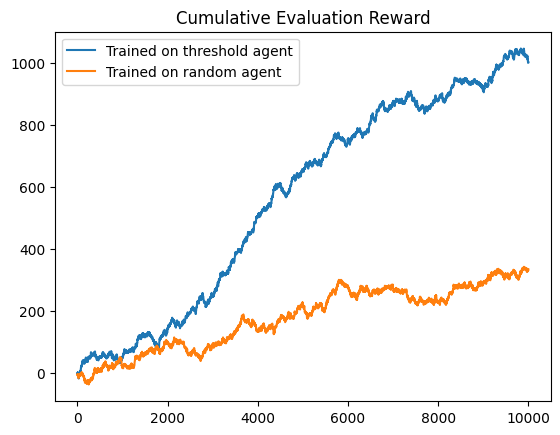

In [9]:

  discount_factor = 0.75

  training_episodes = 10_000     # if increase also decrease α
  eval_games = 10_000

  # get environment ingredients
  start_time = time.time()
  (suits, ranks, non_card_state_fields, non_card_state_fields_arrangements,
  player_id_i, round_i, own_chips_i, opp_chips_i,
  non_card_fields_legality, actions) = create_default_env()
  end_time = time.time()

  ingr_time = end_time - start_time
  print(f"Preparing the environment took {round(ingr_time*1000, 2)} msec.")

  # create environment
  start_time = time.time()
  environ = QEnv(suits, ranks, non_card_state_fields, non_card_fields_legality, actions, player_id_i, round_i, own_chips_i, opp_chips_i)
  end_time = time.time()

  init_time = end_time - start_time
  print(f"Creating the environment took {round(init_time, 2)} sec.")

  # create the agent
  start_time = time.time()

  q_learning_agent_t = QLearningAgent(1, environ, 0.01, discount_factor)
  q_learning_agent_r = QLearningAgent(1, environ, 0.01, discount_factor)
  end_time = time.time()
  agent_init_time = end_time - start_time
  print(f"Creating the agent took {round(agent_init_time, 2)} sec.")

  # create a dummy opponent (just to hold the chips)
  dummy_opp = RandomAgent(2)
  dummy_opp_thresh = ThresholdAgent(2)

  # train the agent using a random agent as part of the environment
  start_time = time.time()
  q_learning_agent_t.train(training_episodes, environ, dummy_opp_thresh, threshhold_trainer=True)
  q_learning_agent_r.train(training_episodes, environ, dummy_opp, threshhold_trainer=False)
  end_time = time.time()
  training_time = end_time - start_time
  print(f"training took {round(training_time, 2)} sec.")

  # derive a policy from the Q table
  q_learning_agent_t.policy = q_learning_agent_t.derive_greedy_policy()
  q_learning_agent_r.policy = q_learning_agent_r.derive_greedy_policy()

  # run evaluation games to see how good the learned policy is
  eval_cumulative_reward_t = 0
  eval_cumulative_rewards_t = []
  for i in range(eval_games):
      print(f"\rRunning evaluation episode {i}", end="", flush=True)
      eval_cumulative_reward_t += q_learning_agent_t.play_eval_game_vs_random(environ, dummy_opp)
      eval_cumulative_rewards_t.append(eval_cumulative_reward_t)

  # run evaluation games to see how good the learned policy is
  eval_cumulative_reward_r = 0
  eval_cumulative_rewards_r = []
  for i in range(eval_games):
      print(f"\rRunning evaluation episode {i}", end="", flush=True)
      eval_cumulative_reward_r += q_learning_agent_t.play_eval_game_vs_random(environ, dummy_opp)
      eval_cumulative_rewards_r.append(eval_cumulative_reward_r)

  print()

  # plot the evaluation reward
  plt.figure()
  t = np.arange(len(eval_cumulative_rewards_t))
  plt.title("Cumulative Evaluation Reward")
  plt.plot(t, eval_cumulative_rewards_t, label=f'Trained on threshold agent')
  plt.plot(t, eval_cumulative_rewards_r, label=f'Trained on random agent')
  plt.legend()


  plt.show()
